# Sentiment Analysis with Hugging Face

Hugging Face is an open-source and platform provider of machine learning technologies. You can use install their package to access some interesting pre-built models to use them directly or to fine-tune (retrain it on your dataset leveraging the prior knowledge coming with the first training), then host your trained models on the platform, so that you may use them later on other devices and apps.

Please, [go to the website and sign-in](https://huggingface.co/) to access all the features of the platform.

[Read more about Text classification with Hugging Face](https://huggingface.co/tasks/text-classification)

The Hugging face models are Deep Learning based, so will need a lot of computational GPU power to train them. Please use [Colab](https://colab.research.google.com/) to do it, or your other GPU cloud provider, or a local machine having NVIDIA GPU.

## Application of Hugging Face Text classification model Fune-tuning

Find below a simple example, with just `3 epochs of fine-tuning`.

Read more about the fine-tuning concept : [here](https://deeplizard.com/learn/video/5T-iXNNiwIs#:~:text=Fine%2Dtuning%20is%20a%20way,perform%20a%20second%20similar%20task.)

In [ ]:
# !pip install datasets
# !pip install transformers
# !pip install accelerate>=0.20.1
# !pip install huggingface_hub
# !pip install accelerate -U
# !pip install transformers[torch]

In [ ]:
import os
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import string
import re
from datasets import load_dataset
from datasets import Dataset
from sklearn.model_selection import train_test_split
import accelerate
import sys
from transformers import AutoTokenizer
from transformers import TrainingArguments
from transformers import AlbertTokenizer, AlbertForSequenceClassification, Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
import numpy as np
from sklearn.metrics import f1_score
from datasets import load_metric
from sklearn.metrics import mean_squared_error
from huggingface_hub import notebook_login
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Disabe W&B
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# Load the dataset and display some values
# df = pd.read_csv('/content/Asset/Train.csv')

In [ ]:
drive.mount('/content/drive')
# Path to the CSV file on Google Drive
csv_file_path = '/content/drive/My Drive/Colab Notebooks/Asset/Train.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)


Mounted at /content/drive


In [ ]:
df.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


# **EDA**

In [ ]:
df.info

<bound method DataFrame.info of        tweet_id                                          safe_text  label  \
0      CL1KWCMY  Me &amp; The Big Homie meanboy3000 #MEANBOY #M...    0.0   
1      E3303EME  I'm 100% thinking of devoting my career to pro...    1.0   
2      M4IVFSMS  #whatcausesautism VACCINES, DO NOT VACCINATE Y...   -1.0   
3      1DR6ROZ4  I mean if they immunize my kid with something ...   -1.0   
4      J77ENIIE  Thanks to <user> Catch me performing at La Nui...    0.0   
...         ...                                                ...    ...   
9996   IU0TIJDI  Living in a time where the sperm I used to was...    1.0   
9997   WKKPCJY6  <user> <user>  In spite of all measles outbrea...    1.0   
9998   ST3A265H  Interesting trends in child immunization in Ok...    0.0   
9999   6Z27IJGD  CDC Says Measles Are At Highest Levels In Deca...    0.0   
10000  P6190L3Q  Pneumonia vaccine: for women w risk of pulmona...    1.0   

       agreement  
0       1.000000  
1    

In [ ]:
df.describe

<bound method NDFrame.describe of        tweet_id                                          safe_text  label  \
0      CL1KWCMY  Me &amp; The Big Homie meanboy3000 #MEANBOY #M...    0.0   
1      E3303EME  I'm 100% thinking of devoting my career to pro...    1.0   
2      M4IVFSMS  #whatcausesautism VACCINES, DO NOT VACCINATE Y...   -1.0   
3      1DR6ROZ4  I mean if they immunize my kid with something ...   -1.0   
4      J77ENIIE  Thanks to <user> Catch me performing at La Nui...    0.0   
...         ...                                                ...    ...   
9996   IU0TIJDI  Living in a time where the sperm I used to was...    1.0   
9997   WKKPCJY6  <user> <user>  In spite of all measles outbrea...    1.0   
9998   ST3A265H  Interesting trends in child immunization in Ok...    0.0   
9999   6Z27IJGD  CDC Says Measles Are At Highest Levels In Deca...    0.0   
10000  P6190L3Q  Pneumonia vaccine: for women w risk of pulmona...    1.0   

       agreement  
0       1.000000  
1  

In [ ]:
# Check for duplicate rows
duplicate_rows = df[df.duplicated()]

# Display the duplicate rows, if any
if not duplicate_rows.empty:
    print("Duplicate Rows:")
    print(duplicate_rows)
    # Optionally, you can drop duplicates
    df = df.drop_duplicates()
    print("Duplicates removed. Updated DataFrame shape:", df.shape)
else:
    print("No duplicate rows found in the DataFrame.")


No duplicate rows found in the DataFrame.


In [ ]:
df.isna().sum()

tweet_id     0
safe_text    0
label        1
agreement    2
dtype: int64

In [ ]:
# A way to eliminate rows containing NaN values
df = df[~df.isna().any(axis=1)]

In [ ]:
df.isna().sum()

tweet_id     0
safe_text    0
label        0
agreement    0
dtype: int64

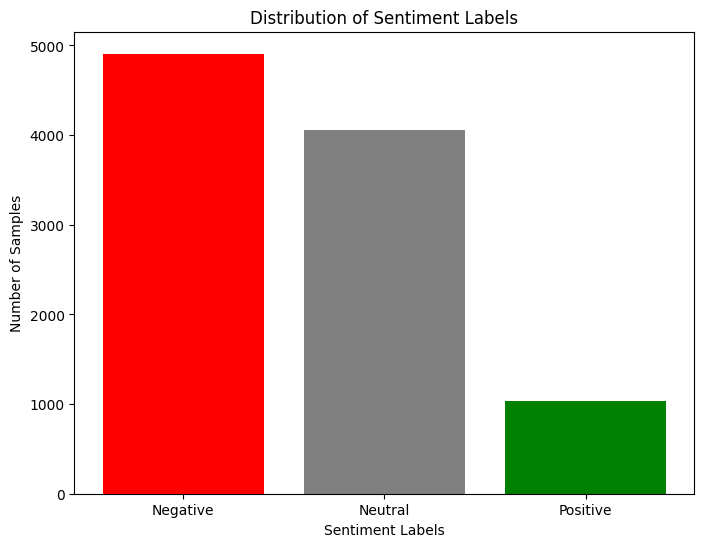

Negative: 49.08%
Neutral: 40.53%
Positive: 10.38%


In [ ]:
# Count the occurrences of each sentiment label
label_counts = df['label'].value_counts()

# Calculate the proportions
total_samples = len(df)
proportions = label_counts / total_samples

# Define sentiment labels
sentiment_labels = ['Negative', 'Neutral', 'Positive']

# Create a bar plot for label distribution
plt.figure(figsize=(8, 6))
plt.bar(sentiment_labels, label_counts, color=['red', 'gray', 'green'])
plt.xlabel('Sentiment Labels')
plt.ylabel('Number of Samples')
plt.title('Distribution of Sentiment Labels')
plt.show()

# Print proportions
for sentiment, proportion in zip(sentiment_labels, proportions):
    print(f"{sentiment}: {proportion:.2%}")


This is to show the distribution and class imbalance distribution in the labels. Positive looks under represented with a little fraction of just 10% of the total distribution

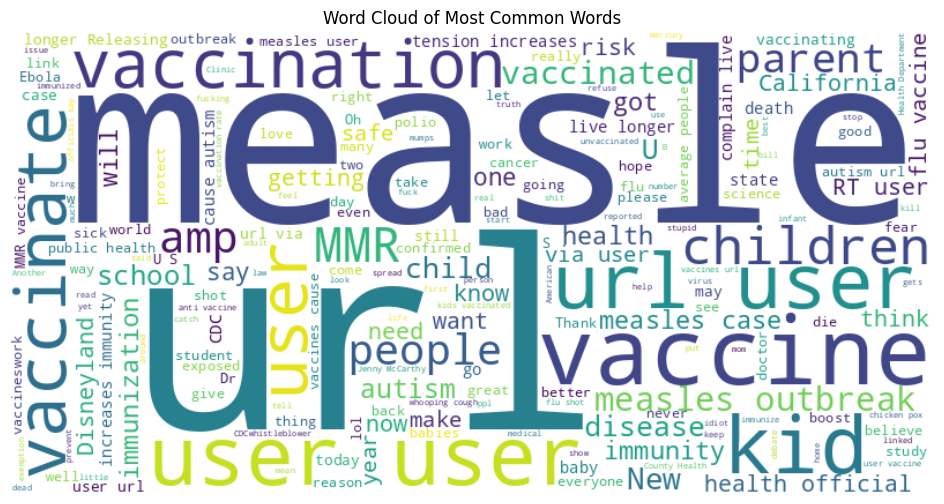

In [ ]:
text_data = df['safe_text']

# Combine all text data into a single string
all_text = " ".join(text_data)

# Create a WordCloud visualization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Display the WordCloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud of Most Common Words')
plt.show()


There chart shows a representation of the most used words in the associated tweets collected for this project

In [ ]:
def remove_user_url(text):
    cleaned_text = re.sub(r'\b\w*user\w*\b|\b\w*url\w*\b', '', text, flags=re.IGNORECASE)
    return cleaned_text

# Use .loc to explicitly modify the 'safe_text' column in the original DataFrame
df['safe_text'] = df['safe_text'].apply(lambda x: remove_user_url(x))


**Removing irrelevant and repetitive words in the dataset**

In [ ]:
def remove_special_characters(text):
    # Remove special characters, punctuation, and digits
    cleaned_text = re.sub(r'[^\w\s]|[\d]+', '', text)
    return cleaned_text

# Apply the function to the 'safe_text' column
df['safe_text'] = df['safe_text'].apply(remove_special_characters)

This action with it resulting code removes anything but text and aphalbets to give us clarity and consistent convention in the sentences which will in turn help the model perform well

In [ ]:
df.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me amp The Big Homie meanboy MEANBOY MB MBS MM...,0.0,1.0
1,E3303EME,Im thinking of devoting my career to proving ...,1.0,1.0
2,M4IVFSMS,whatcausesautism VACCINES DO NOT VACCINATE YOU...,-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to Catch me performing at La Nuit NYC ...,0.0,1.0


Agreement Statistics:
count    9999.000000
mean        0.854252
std         0.180707
min         0.333333
25%         0.666667
50%         1.000000
75%         1.000000
max         1.000000
Name: agreement, dtype: float64


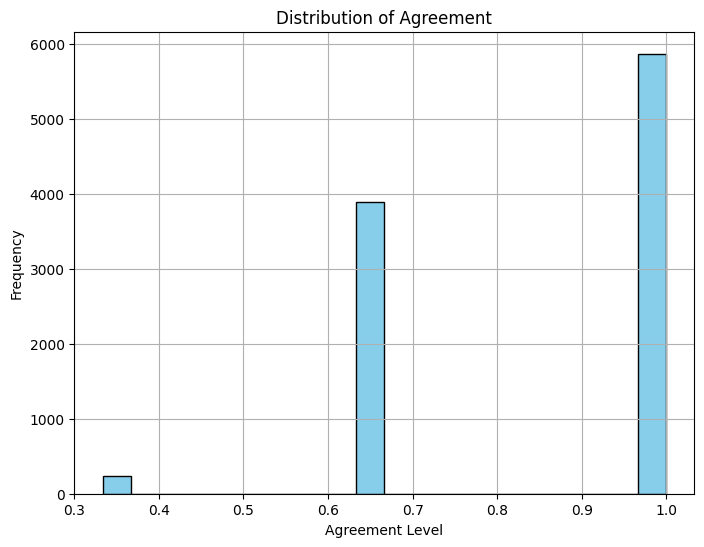

In [ ]:
# Calculate the agreement statistics
agreement_stats = df['agreement'].describe()

# Print the statistics
print("Agreement Statistics:")
print(agreement_stats)

# Visualize the distribution of agreement
plt.figure(figsize=(8, 6))
plt.hist(df['agreement'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Agreement Level')
plt.ylabel('Frequency')
plt.title('Distribution of Agreement')
plt.grid(True)
plt.show()


There visuals above gives insight into the distribution of the agreements held and it proportional statistics over the period of the collation of the tweets.

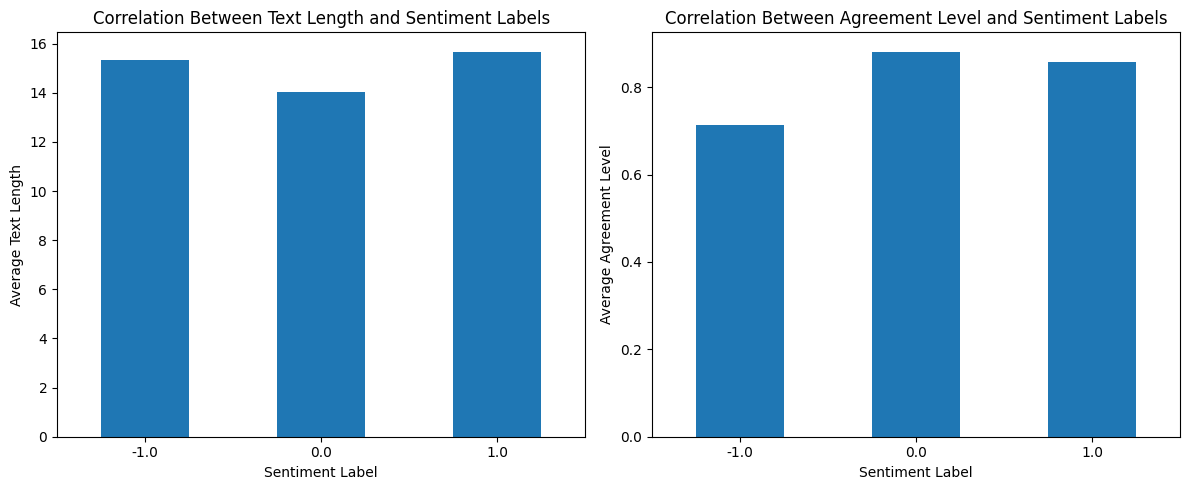

In [ ]:
# Calculate text length (e.g., word count) for each row and add it as a new column
# df['text_length'] = df['cleaned_text'].apply(lambda x: len(x.split()))
df['text_length'] = df['safe_text'].apply(lambda x: len(x.split()))

# Correlation between text length and sentiment labels
correlation_length_label = df.groupby('label')['text_length'].mean()

# Correlation between agreement level and sentiment labels
correlation_agreement_label = df.groupby('label')['agreement'].mean()

# Visualize correlations
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
correlation_length_label.plot(kind='bar', rot=0)
plt.title('Correlation Between Text Length and Sentiment Labels')
plt.xlabel('Sentiment Label')
plt.ylabel('Average Text Length')

plt.subplot(1, 2, 2)
correlation_agreement_label.plot(kind='bar', rot=0)
plt.title('Correlation Between Agreement Level and Sentiment Labels')
plt.xlabel('Sentiment Label')
plt.ylabel('Average Agreement Level')

plt.tight_layout()
plt.show()

This is to imply that there is probable course to assume that the length of a text or agreement is in correlation to kind of sentiment generated

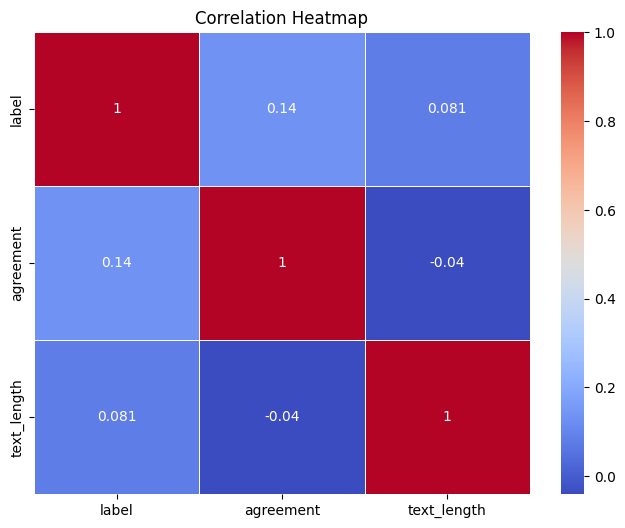

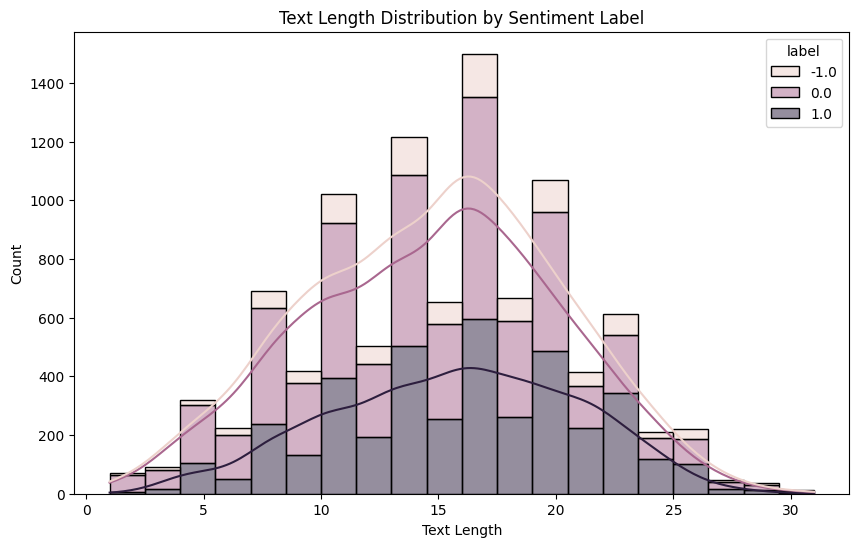

In [ ]:
# Create a heatmap to explore correlations between variables
correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

# Plot histograms to explore the text length distribution for each sentiment class
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', hue='label', multiple='stack', bins=20, kde=True)
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.title('Text Length Distribution by Sentiment Label')
plt.show()




The above exploration is to show the correlation among the associated variables presented.It shows certain instance instances of posotive correlations among the variables with a return of non to negatively weaker instances in some cases. The next chart is a histogram based on the text length of distribution by sentiment labels, measuring how related the length of a text length is to the sentiment it generates. In some cases it shows how lengthy text are associated with negative sentiments.

In [ ]:
# Display a few examples for each sentiment class

# List of unique sentiment labels (positive, neutral, negative)
sentiment_labels = df['label'].unique()

# Define the number of examples to display for each class
num_examples_per_class = 5

# Loop through each sentiment class
for label in sentiment_labels:
    # Filter the DataFrame for samples with the current sentiment label
    samples = df[df['label'] == label]['safe_text'].sample(num_examples_per_class)

    # Display the sentiment label and corresponding text samples
    print(f"Sentiment Label: {label}")
    for i, text in enumerate(samples):
        print(f"Example {i + 1}: {text}\n")


Sentiment Label: 0.0
Example 1:  This bitch on sc finna get the measles at disneyland ijus seen sumn that said stay away from disneyland

Example 2:  Personal belief exemptions werent always this lax Im w you on who did what being less important than vaccinations

Example 3: I will let my kids roll in the mud And play with animals And climb trees Build their immunity and their toughness

Example 4: ALERT  Health Officials Warn Of Seattle Airport Measles Exposure 

Example 5: StopEbolaStrike STOP THE FLIGHTS FROM THE HOTZONES NOW 
BTW What recently happened to the BampM GATES vaccinated children in india

Sentiment Label: 1.0
Example 1: why would you not vaccinate your kids

Example 2: Presenting on the importance of influenza vaccination Get vaccinated Protect children protect coworkers protect family protect yourself

Example 3: Make Vaccines Mandatory to Attend California Schools  

Example 4: Theres also a serious side effect for not vaccinating your kid Its called polio measles mum

we see a few examples (in this case, 5) for each sentiment class, allowing us to examine the actual text content associated with different sentiment labels in your dataset. This can help us understand the sentiment patterns and the types of text examples your model will be trained on.

In [ ]:
df.head()

,tweet_id,safe_text,label,agreement,text_length
0,CL1KWCMY,Me amp The Big Homie meanboy MEANBOY MB MBS MM...,0.0,1.0,13
1,E3303EME,Im thinking of devoting my career to proving ...,1.0,1.0,24
2,M4IVFSMS,whatcausesautism VACCINES DO NOT VACCINATE YOU...,-1.0,1.0,7
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0,28
4,J77ENIIE,Thanks to Catch me performing at La Nuit NYC ...,0.0,1.0,16


I manually split the training set to have a training subset ( a dataset the model will learn on), and an evaluation subset ( a dataset the model with use to compute metric scores to help use to avoid some training problems like [the overfitting](https://www.ibm.com/cloud/learn/overfitting) one ).

There are multiple ways to do split the dataset. You'll see two commented line showing you another one.

**Data Preparation**

In [ ]:
# Split the original data
train, eval = train_test_split(df, test_size=0.2, random_state=40, stratify=df['label'])

In [ ]:
train.head()

,tweet_id,safe_text,label,agreement,text_length
3389,HK43EYLX,Children receive vaccinations before school It...,0.0,0.666667,17
8635,3BWLQK25,Rabid cats capture leads to vaccination remind...,1.0,0.666667,15
4406,9KKVJ51T,BREAKING Two suspected measles cases being mon...,0.0,1.000000,16
8624,VOF67NGH,Mickey Minnie and measles for nine Disneyland ...,0.0,0.666667,17
3454,9B1WHXX5,Finally rt California cracks down on vaccine ...,1.0,0.666667,9


In [ ]:
eval.head()

,tweet_id,safe_text,label,agreement,text_length
9276,MU0AZP0A,Parenting checklist dont vaccinate kid Take th...,0.0,0.666667,9
8805,QHAQXRI9,Thoughts on World Autism Awareness Day from a ...,0.0,1.000000,13
511,FFJQ2Q4N,So the expenditure of money is comparable to ...,-1.0,0.333333,22
3290,39EE91VG,More than parents arrested for not allowing ...,1.0,1.000000,16
6588,PAKFM4QV,City of Milwaukee offers measles immunization ...,1.0,0.666667,19


In [ ]:
print(f"new dataframe shapes: train is {train.shape}, eval is {eval.shape}")

# Check for duplicates in 'train' dataset
train_duplicates = train[train.duplicated()]
print(f"Number of duplicates in 'train': {len(train_duplicates)}")

# Check for NaN values in 'train' dataset
train_nan = train.isna().sum()
print("NaN counts in 'train':")
print(train_nan)

# Check for duplicates in 'eval' dataset
eval_duplicates = eval[eval.duplicated()]
print(f"Number of duplicates in 'eval': {len(eval_duplicates)}")

# Check for NaN values in 'eval' dataset
eval_nan = eval.isna().sum()
print("NaN counts in 'eval':")
print(eval_nan)

new dataframe shapes: train is (7999, 5), eval is (2000, 5)
Number of duplicates in 'train': 0
NaN counts in 'train':
tweet_id       0
safe_text      0
label          0
agreement      0
text_length    0
dtype: int64
Number of duplicates in 'eval': 0
NaN counts in 'eval':
tweet_id       0
safe_text      0
label          0
agreement      0
text_length    0
dtype: int64


In [ ]:
# Save splitted subsets
train.to_csv("../content//drive/My Drive/Colab Notebooks/Asset/train_subset.csv", index=False)
eval.to_csv("../content//drive/My Drive/Colab Notebooks/Asset/eval_subset.csv", index=False)

In [ ]:
notebook_login()

In [ ]:
# Load the datasets for imbalanced and balanced data
dataset = load_dataset('csv',
                        data_files={'train': '../content//drive/My Drive/Colab Notebooks/Asset/train_subset.csv',
                        'eval': '../content//drive/My Drive/Colab Notebooks/Asset/eval_subset.csv'}, encoding = "ISO-8859-1")


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

In [ ]:
# Load the ALBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('albert-base-v2')

In [ ]:
def transform_labels(label):

    label = label['label']
    num = 0
    if label == -1: #'Negative'
        num = 0
    elif label == 0: #'Neutral'
        num = 1
    elif label == 1: #'Positive'
        num = 2

    return {'labels': num}

In [ ]:
def tokenize_data(example):
  return tokenizer(example['safe_text'], padding='max_length', truncation=True, return_tensors='pt')

# Change the tweets to tokens that the models can exploit
dataset = dataset.map(tokenize_data, batched=True)

# Transform	labels and remove the useless columns
remove_columns = ['tweet_id', 'label', 'safe_text', 'agreement','text_length']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 7999
    })
    eval: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
})

In [ ]:
training_args = TrainingArguments(
    # output_dir='./milan_model',
    "sentiment_analysis",
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    load_best_model_at_end=True,
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=1000,
    save_steps=1000,
    push_to_hub=True,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


**Modeling**

In [ ]:
# Loading a pretrain model while specifying the number of labels in our dataset for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained("albert-base-v2", num_labels=3)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset = dataset['train'].shuffle(seed=10)
eval_dataset = dataset['eval'].shuffle(seed=10)

**Evaluation**

In [ ]:
def compute_f1_score(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    f1 = f1_score(labels, preds, average="weighted")
    return {"f1_score": f1}

In [ ]:
# Define a function to compute accuracy
metric = load_metric("accuracy")

def compute_accuracy(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_f1_score,
)

In [ ]:
# Launch the learning process: training
trainer.train()

Step,Training Loss,Validation Loss,F1 Score
1000,0.871700,0.843334,0.560780
2000,0.889900,0.951472,0.407491
3000,0.967300,0.951046,0.323382
4000,0.958900,0.952395,0.323382
5000,0.969400,0.954634,0.323382
6000,0.971900,0.950333,0.323382
7000,0.953300,0.951068,0.323382
8000,0.960300,0.951119,0.323382
9000,0.961100,0.950133,0.323382


KeyboardInterrupt: ignored

In [ ]:
# trainer.push_to_hub()

In [ ]:
# Launch the final evaluation
eval_metrics = trainer.evaluate()

for key, value in eval_metrics.items():
  print(f"{key}:{value}")

# print("Evaluation metrics:", eval_metrics)

Step,Training Loss,Validation Loss,F1 Score
1000,0.871700,0.843334,0.560780
2000,0.889900,0.951472,0.407491
3000,0.967300,0.951046,0.323382
4000,0.958900,0.952395,0.323382
5000,0.969400,0.954634,0.323382
6000,0.971900,0.950333,0.323382
7000,0.953300,0.951068,0.323382
8000,0.960300,0.951119,0.323382
9000,0.961100,0.950133,0.323382
9107,0.961100,0.950045,0.323382


eval_loss:0.9500445127487183
eval_f1_score:0.3233816230717639


Some checkpoints of the model are automatically saved locally in `test_trainer/` during the training.

You may also upload the model on the Hugging Face Platform... [Read more](https://huggingface.co/docs/hub/models-uploading)

This notebook is inspired by an article: [Fine-Tuning Bert for Tweets Classification ft. Hugging Face](https://medium.com/mlearning-ai/fine-tuning-bert-for-tweets-classification-ft-hugging-face-8afebadd5dbf)

Do not hesitaite to read more and to ask questions, the Learning is a lifelong activity.